In [ ]:
%load_ext wurlitzer # redirect C/C++ log to ipython

# tensorflow

In [ ]:
import tensorflow as tf

# log-related
from tensorflow.compat.v1.logging import log, log_if, log_first_n, set_verbosity
from tensorflow.compat.v1.logging import INFO, ERROR, DEBUG, WARN

set_verbosity(INFO)


## logging format

In [ ]:
import logging
import logging.handlers

tfLog = logging.getLogger('tensorflow')
# adds .1s after %(levelname) in order to be "I" instead of "INFO"
# changes datetime format as well
formatter = logging.Formatter('[%(levelname).1s %(asctime)s %(filename)s:\
%(lineno)d] %(message)s',datefmt='%m-%d %H:%M')
# add formatter to each handler (default one)
for h in tfLog.handlers:
    h.setFormatter(formatter)
    
set_verbosity(INFO)

In [ ]:
log(INFO,f"version:{tf.__version__} with GPU? {tf.test.is_gpu_available()}")

## common settings

In [ ]:
# 按需设置显存
gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))   

禁用gpu

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

## app.flags usage

In [ ]:
tf.app.flags.DEFINE_string('gpus', None, 'gpus to use')
tf.app.flags.DEFINE_integer('batch_size', 5, 'batch size')

## tensorboard - 自制

In [1]:
from __future__ import print_function
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'
# InteractiveShell.ast_node_interactivity='last_expr'

from matplotlib import pyplot as plt
# plt.style.use(['science','ieee','no-latex','grid','high-contrast','notebook']) # high-contrast指的是配色的选取
# plt.style.use(['science','ieee','no-latex','high-contrast','notebook']) # high-contrast指的是配色的选取
%pylab inline

# %load_ext autoreload
# %autoreload 2
import numpy as np
import pandas as pd 
pd.options.display.max_rows=5  # 设置dataframe最多的显示行数
import os
from os import path as osp
import sys
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
    print(f"After inserting, sys.path is {sys.path}")
    
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


In [8]:
def getData(path_pre, path_key, topoName):
    datas = {}
    # hard code here
    for seed in [3, 66, 102]:
        log_path = osp.join(path_pre, f'{topoName}-{seed}-{path_key}', "perfm.log")
        datas[seed] = np.loadtxt(log_path)

    return datas

def smooth(scalar, weight=0.85):  #weight 平滑度，tensorboard 默认0.6
    last = scalar[0]
    smoothed = []
    for point in scalar:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

def plot_smoothed(datas, plot_ori=True):
    # get smoothed data
    datas_smoothed = {}
    for seed, perfm in datas.items():
        datas_smoothed[seed] = smooth(perfm, 0.8)

    # draw smoothed data
    colors = []
    for seed, perfm in datas_smoothed.items():
        line = plt.plot(range(len(perfm)), perfm, label=seed)
        colors.append(line[0].get_color())

    plt.legend()
    yLim = plt.gca().get_ylim()
    xLim = plt.gca().get_xlim()
    # print(f"xLim is {xLim}，yLim is {yLim}")

    # plot original data with transparency if needed
    if plot_ori:
        index = 0
        for seed, perfm in datas.items():
            plt.plot(range(len(perfm)), perfm, label=seed, alpha=0.3, color=colors[index])
            index += 1

        index = 0
        # redraw to make smoothed data on top
        for seed, perfm in datas_smoothed.items():
            plt.plot(range(len(perfm)), perfm, label=seed, color=colors[index])
            index += 1

    plt.xlim(xLim)
    plt.ylim(yLim)
    plt.grid()


In [3]:
path_pre="/home/hesy/projects/g1/pro/mars/para/log_single/log/"
path_key="32-60-5-0-9437-0-changePath3_oriTM"
topoName="Nine"
datas = getData(path_pre,path_key,topoName)

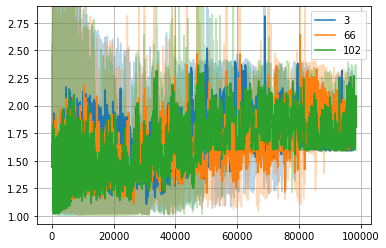

In [9]:
plot_smoothed(datas)

# torch

## difference between expand and repeat

In [12]:
y = torch.tensor([[1], [2], [3]])
x = torch.tensor([1,2,3])

In [63]:
x.repeat(3, 2)
y.repeat(3, 2)
y.expand(3, 2)
print(f"x.size is {x.size} and size after repeat is {x.repeat(3, 2).size()}" )
print(f"y.size is {y.size} and size after repeat is {y.repeat(3, 2).size()}" )
print(f"y.size is {y.size} and size after expand is {y.expand(3, 2).size()}" )

tensor([[1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3],
        [1, 2, 3, 1, 2, 3]])

tensor([[1, 1],
        [2, 2],
        [3, 3],
        [1, 1],
        [2, 2],
        [3, 3],
        [1, 1],
        [2, 2],
        [3, 3]])

tensor([[1, 1],
        [2, 2],
        [3, 3]])

x.size is <built-in method size of Tensor object at 0x7f4eb3f96828> and size after repeat is torch.Size([3, 6])
y.size is <built-in method size of Tensor object at 0x7f4eb369e360> and size after repeat is torch.Size([9, 2])
y.size is <built-in method size of Tensor object at 0x7f4eb369e360> and size after expand is torch.Size([3, 2])


# gym

In [71]:
import gym
gym.__version__

'0.15.3'

## CartPole-v0

In [ ]:
env = gym.make('CartPole-v0') 
env.seed(1) # 设置env随机种子
env.observation_space  # 速度，角速度，x
env.action_space
n_states = env.observation_space.shape[0] # 获取总的状态数
n_actions = env.action_space.n # 获取总的动作数

## Callable
callable就是类的<u>实例</u>可以像函数一样调用

In [8]:
class Stu(object):
    test= 0
    def __init__(self, name):
        self.name = name
    def __call__(self, *args, **kwargs):
        self.run()

    def run(self):
        print('{name} is running'.format(name=self.name))
        
    def updateTest(self,num):
        print(f"id of self.test is {id(self.test)}")
        self.test=num
        print(f"self.test's value and id after change is ({self.test},{id(self.test)})")

stu = Stu('小明')
print(callable(stu))    # True
stu()   
print(id(Stu.test))
stu.updateTest(3)

True
小明 is running
93915877628576
id of self.test is 93915877628576
self.test's value and id after change is (3,93915877628672)
